# Lecture 13: Tree2 Part 2
Example for Decision Tree

We will study the [Titanic: Machine learning from Disaster](https://www.kaggle.com/competitions/titanic/data?select=train.csv) dataset and predict who would survive from the disaster.

The training data provided contains 891 records with the following attributes:
* Survived: 0= No; 1 = Yes
* Pclass: Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
* Name: Passenger name 
dataset.
* Gender: (female; male)
* Age: Passenger age
* SibSp: Number of Siblings/Spouses Aboard
* Parch: Number of Parents/Children Aboard
* Ticket:Ticket Number
* Fare: Passenger Fare
* Cabin: Cabin
* Embarked: Port of Embarkation (C = Cherbourg; Q =Queenstown; S = Southampton)

Let us load the data into a Pandas dataframe and get rid of some information that is incomplete. 

In this case, we will ignore the Ticket and Cabin columns, and drop instances without values in the rest of the dataframe

In [ ]:
import pandas as pd
titanic = pd.read_csv('titanic_train.csv')
titanic = titanic.drop(['Ticket','Cabin'], axis=1)
titanic = titanic.dropna()

There is some extra information that may help us navigate the use of the various attributes in the dataset. Famously, the ship did not have enough lifeboats for all the crew and passengers. Furthermore, the lifeboats used were not used at full capacity. Passengers in the upper classes were the first to be helped out, leaving the rest to fend for themselves.

We can assume that the old adage of “Women and children first” may have applied. 

With that in mind, let us perform some data exploration and see the percentage of passengers who survived the disaster, categorised by travelling class and gender.

In [ ]:
# We first construct a crossta of the travel class vs survival 
Pclas_pct = pd.crosstab(titanic.Pclass.astype('category'), titanic.Survived.astype('category'), margins=True)

# We can use Pandas to calculate the percentage of survivors per class.
Pclas_pct['Percent'] = Pclas_pct[1]/(Pclas_pct[0]+Pclas_pct[1])

# Now for the gender
Gender_pct = pd.crosstab(titanic.Gender.astype('category'), titanic.Survived.astype('category'), margins=True)

Gender_pct['Percent'] = Gender_pct[1]/(Gender_pct[0]+Gender_pct[1])

# Let us now look at the numbers
print(Pclas_pct['Percent'])
print(Gender_pct['Percent'])

For our modelling we will use a subset of the features provided and concentrate on three things: 
*Class*, *gender* and *age*. 

Remember that Scikit-learn only accepts numerical values as data, and in this case the Gender feature is given as text, i.e “female” and “male”. 

Let us pre-process our data with Pandas to obtain dummy variables to encode the information in numerical labels

In [ ]:
titanic = pd.concat([titanic, pd.get_dummies(titanic['Gender'])], axis=1)
# This appends two columns to our dataframe, one called female and the other one called male, indicating the values with 0 or 1.

We are now ready to start our modelling. Scikit-learn provides a decision tree model in *DecisionTreeClassifier*, accepting various parameters such as the impurity criterion taking values such as *entropy* and *gini*.

We can also affect the pruning with parameters such as *max_depth* and *min_samples_leaf*, the former determines the the maximum depth (levels) of the tree, whereas the latter determines the minimum number of data instances required to split an internal node.

Let us use *GridSearchCV* to determine the best values of the maximum depth and minimum number of samples. We start by splitting our data into training and testing:

In [ ]:
X = titanic[['Pclass','Age','female']]  # Note we are using the dummy variable female instead of Gender
Y = titanic['Survived']

import numpy as np
import sklearn.model_selection as ms
from sklearn import tree
from sklearn.model_selection import GridSearchCV

XTrain, XTest, YTrain, YTest = ms.train_test_split(X, Y, test_size= 0.3, random_state=1)

depth_val = np.arange(2,11)
leaf_val = np.arange(1,31, step=9)

grid_s = [{'max_depth': depth_val,'min_samples_leaf': leaf_val}]
model = tree.DecisionTreeClassifier(criterion='entropy')

cv_tree = GridSearchCV(estimator=model,param_grid=grid_s,cv=ms.KFold(n_splits=10))
cv_tree.fit(XTrain, YTrain)

best_depth = cv_tree.best_params_['max_depth']

best_min_samples = cv_tree.best_params_['min_samples_leaf']

print(best_depth, best_min_samples)

Train with the best parameters and predict the test set.

In [ ]:
model = tree.DecisionTreeClassifier(criterion='entropy',max_depth=best_depth,min_samples_leaf=best_min_samples)

TitanicTree = model.fit(XTrain, YTrain)

survive_pred = TitanicTree.predict(XTest)

survive_proba = TitanicTree.predict_proba(XTest)

Make the confusion matrix. And you can evaluate the model accuracy by yourself from here.

In [ ]:
from sklearn import metrics
metrics.confusion_matrix(YTest, survive_pred)

Scikit-learn enables us to generate a [Graphviz](https://graphviz.org) visualization of the tree.

In [ ]:
tree.export_graphviz(TitanicTree, out_file='TitanicTree.dot', max_depth=3, feature_names=X.columns, class_names=['Dead','Survived'])
# This code will generate a .dot file that can be visualised with Graphviz.

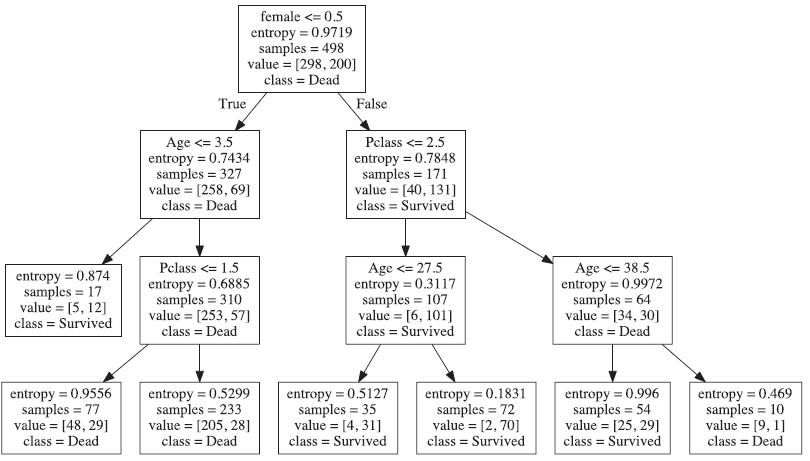